In [1]:
# Draw data with Kaggle API

# 🔽 kaggle.json file
from google.colab import files
files.upload()

# 🔐 Kaggle API setup
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


Saving kaggle (2).json to kaggle (2).json


In [2]:
# 📦 Download competition data
!kaggle competitions download -c lanl-earthquake-prediction

# 📂 unzip files
!unzip lanl-earthquake-prediction.zip


 99% 2.25G/2.27G [00:06<00:00, 322MB/s]
100% 2.27G/2.27G [00:06<00:00, 397MB/s]
Archive:  lanl-earthquake-prediction.zip
  inflating: sample_submission.csv   
  inflating: test/seg_00030f.csv     
  inflating: test/seg_0012b5.csv     
  inflating: test/seg_00184e.csv     
  inflating: test/seg_003339.csv     
  inflating: test/seg_0042cc.csv     
  inflating: test/seg_004314.csv     
  inflating: test/seg_004cd2.csv     
  inflating: test/seg_004ee5.csv     
  inflating: test/seg_004f1f.csv     
  inflating: test/seg_00648a.csv     
  inflating: test/seg_006e4a.csv     
  inflating: test/seg_007a37.csv     
  inflating: test/seg_00a37e.csv     
  inflating: test/seg_00be11.csv     
  inflating: test/seg_00c35b.csv     
  inflating: test/seg_00cc91.csv     
  inflating: test/seg_00e5f7.csv     
  inflating: test/seg_00f3b9.csv     
  inflating: test/seg_010eab.csv     
  inflating: test/seg_0125d9.csv     
  inflating: test/seg_0144cb.csv     
  inflating: test/seg_0165c6.csv     
  inf

In [4]:
import pandas as pd

# Load a manageable chunk of the dataset (e.g., 5 million rows)
file_path = "/content/train.csv"
chunk = pd.read_csv(file_path, nrows=5_000_000)

# Preview the data
chunk.head()


,acoustic_data,time_to_failure
0,12,1.4691
1,6,1.4691
2,8,1.4691
3,5,1.4691
4,8,1.4691


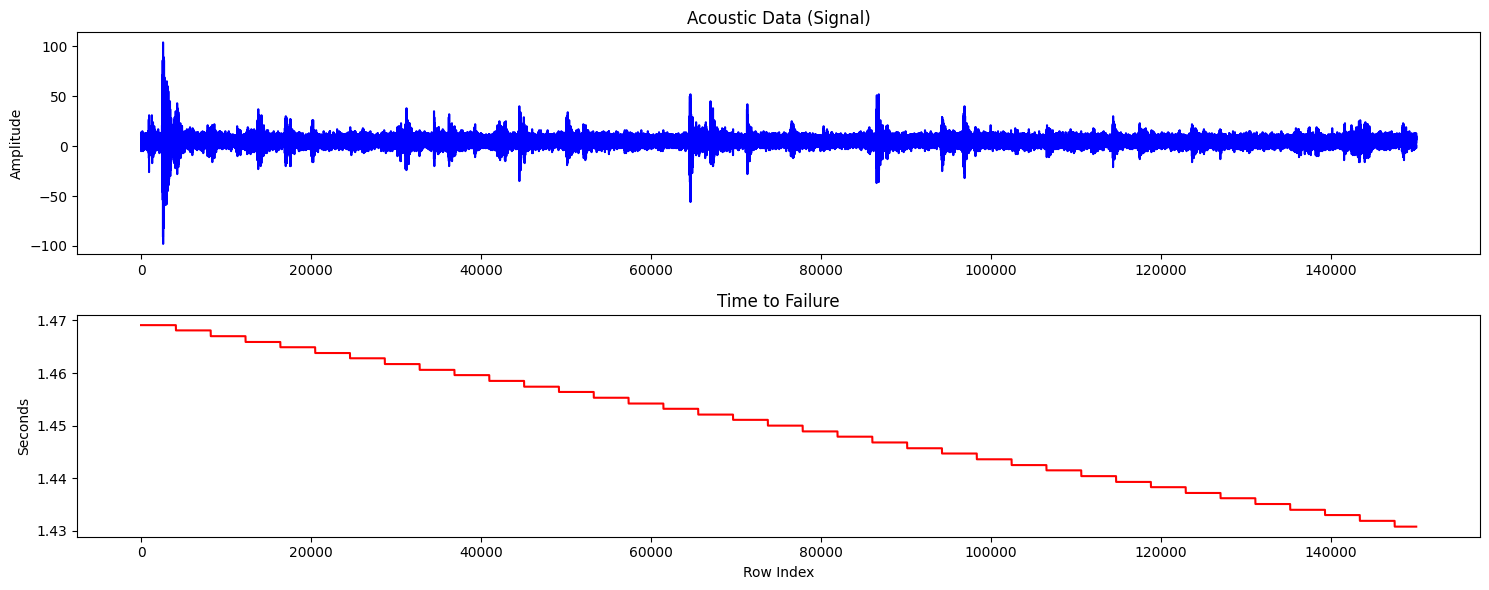

In [5]:
# Visualize the Signal and Target

import matplotlib.pyplot as plt

# Visualize the first 150,000 rows
subset = chunk.iloc[:150000]

plt.figure(figsize=(15, 6))

# Plot acoustic_data
plt.subplot(2, 1, 1)
plt.plot(subset['acoustic_data'], color='blue')
plt.title("Acoustic Data (Signal)")
plt.ylabel("Amplitude")

# Plot time_to_failure
plt.subplot(2, 1, 2)
plt.plot(subset['time_to_failure'], color='red')
plt.title("Time to Failure")
plt.ylabel("Seconds")
plt.xlabel("Row Index")

plt.tight_layout()
plt.show()


#### Segment-Based Feature Engineering
In this step, we will split the train.csv file into segments. Each segment will:

- Consist of 150,000 rows (approximately 1 second of recording)

- Extract X (features) from each segment

- The time_to_failure value at the end of the segment will be y (target)

In [7]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm

# Path to train.csv
TRAIN_PATH = '/content/train.csv'

# Constants
ROWS_PER_SEGMENT = 150_000
TOTAL_ROWS = 629_145_480
TOTAL_SEGMENTS = TOTAL_ROWS // ROWS_PER_SEGMENT

# Predefine feature names
feature_names = ["mean", "std", "min", "max", "q01", "q05", "q95", "q99"]
X = pd.DataFrame(columns=feature_names, dtype=np.float32)
y = []

# Chunked reading
reader = pd.read_csv(TRAIN_PATH, chunksize=ROWS_PER_SEGMENT, dtype={'acoustic_data': np.int16, 'time_to_failure': np.float32})

for i, chunk in tqdm(enumerate(reader), total=TOTAL_SEGMENTS):
    features = {
        "mean": chunk["acoustic_data"].mean(),
        "std": chunk["acoustic_data"].std(),
        "min": chunk["acoustic_data"].min(),
        "max": chunk["acoustic_data"].max(),
        "q01": chunk["acoustic_data"].quantile(0.01),
        "q05": chunk["acoustic_data"].quantile(0.05),
        "q95": chunk["acoustic_data"].quantile(0.95),
        "q99": chunk["acoustic_data"].quantile(0.99),
    }
    X.loc[i] = features
    y.append(chunk["time_to_failure"].values[-1])

# Convert y to Series
y = pd.Series(y, name="time_to_failure")


4195it [03:06, 22.44it/s]                          


In [9]:
X.shape


(4195, 8)

In [10]:
y.shape


(4195,)

In [11]:
X.head()


,mean,std,min,max,q01,q05,q95,q99
0,4.884113,5.101106,-98,104,-8.0,-2.0,11.0,18.0
1,4.725767,6.588824,-154,181,-11.0,-2.0,12.0,21.0
2,4.906393,6.967397,-106,140,-15.0,-3.0,13.0,26.0
3,4.902240,6.922305,-199,197,-12.0,-2.0,12.0,22.0
4,4.908720,7.301110,-126,145,-15.0,-2.0,12.0,26.0


In [12]:
# Train/Test Split + Scaling

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [13]:
# Train & Evaluate Multiple Models

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_log_error
import numpy as np

# Helper function to calculate RMSLE
def rmsle(y_true, y_pred):
    return np.sqrt(mean_squared_log_error(y_true, np.maximum(0, y_pred)))

# Models to evaluate
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=100, random_state=42, verbosity=0)
}

# Train and evaluate
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    preds = model.predict(X_test_scaled)
    score = rmsle(y_test, preds)
    print(f"{name} RMSLE: {score:.5f}")


Linear Regression RMSLE: 0.57256
Ridge Regression RMSLE: 0.57195
Random Forest RMSLE: 0.54010
XGBoost RMSLE: 0.56362


In [14]:
# RandomizedSearchCV for Random Forest

from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import randint
import numpy as np

# Define parameter grid
param_dist = {
    "n_estimators": randint(50, 300),
    "max_depth": [None] + list(np.arange(5, 30)),
    "min_samples_split": randint(2, 10),
    "min_samples_leaf": randint(1, 10),
    "max_features": ["auto", "sqrt", "log2"]
}

# Initialize model
rf_model = RandomForestRegressor(random_state=42)

# Randomized search
random_search = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=param_dist,
    n_iter=50,
    scoring="neg_root_mean_squared_log_error",
    cv=3,
    verbose=2,
    n_jobs=-1,
    random_state=42
)

# Fit the search
random_search.fit(X_train, y_train)

# Best model
best_rf_model = random_search.best_estimator_

# Predict and evaluate
y_pred_rf_tuned = best_rf_model.predict(X_test)
rmsle_rf_tuned = np.sqrt(np.mean(np.square(np.log1p(y_test) - np.log1p(y_pred_rf_tuned))))
print(f"Tuned RandomForest RMSLE: {rmsle_rf_tuned:.5f}")


Fitting 3 folds for each of 50 candidates, totalling 150 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
57 fits failed out of a total of 150.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
29 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/

Tuned RandomForest RMSLE: 0.52729


In [18]:
# Feature Extraction from Test Segments

import os
import pandas as pd
import numpy as np
from tqdm import tqdm

# Load the sample submission template
submission = pd.read_csv('/content/sample_submission.csv')

# Path to test segments
test_folder = '/content/test'

# Create an empty list to store extracted features
features_list = []

# Loop through each test segment and extract statistical features
for seg_id in tqdm(submission['seg_id']):
    seg_path = os.path.join(test_folder, seg_id + '.csv')
    seg = pd.read_csv(seg_path)
    x = seg['acoustic_data'].values

    features = {
        "mean": x.mean(),
        "std": x.std(),
        "min": x.min(),
        "max": x.max(),
        "q01": np.quantile(x, 0.01),
        "q05": np.quantile(x, 0.05),
        "q95": np.quantile(x, 0.95),
        "q99": np.quantile(x, 0.99),
    }
    features_list.append(features)

# Concatenate the list of features into a DataFrame
X_test = pd.DataFrame(features_list)

100%|██████████| 2624/2624 [00:40<00:00, 64.93it/s]


In [20]:
import joblib

# Save the best model
joblib.dump(best_rf_model, 'best_random_forest_model.pkl')

print("Model saved successfully!")

Model saved successfully!


In [19]:
# Make predictions on the test set
# Using the best_rf_model from the previous tuning step
y_pred_test = best_rf_model.predict(X_test)

# Ensure predictions are non-negative
y_pred_test[y_pred_test < 0] = 0

# Create the submission file
submission['time_to_failure'] = y_pred_test

# Save the submission file
submission.to_csv('submission.csv', index=False)

print("Submission file created successfully!")

Submission file created successfully!


In [21]:
# Test Dataframes(5 Segments) creating for Streamlit App

import pandas as pd

# Step 1: Load only the necessary column
train = pd.read_csv("/content/train.csv", usecols=["acoustic_data"], nrows=750000)

# Step 2: Create and save 5 segments
segment_length = 150000

for i in range(5):
    start = i * segment_length
    end = (i + 1) * segment_length
    segment = train.iloc[start:end]
    segment.to_csv(f"test_segment_{i+1}.csv", index=False)

print("✅ Segments saved!")


✅ Segments saved!
